<a href="https://colab.research.google.com/github/prachuryanath/TF-Learning/blob/main/Transfer_Learning_with_Tensorflow_Part_1_Feature_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Transfer Learning with Tensorflow Part 1: Feature Extraction**
Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem.

There are two main benefits:

1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data


In [1]:
!nvidia-smi

Thu May 13 16:33:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## **Downloading and becoming one with the data**

In [2]:
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2021-05-13 16:33:50--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.188.128, 64.233.189.128, 108.177.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.188.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  39.0MB/s    in 4.1s    

2021-05-13 16:33:55 (39.0 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent

## **Creating data loaders (preparing the data)**

Now we've downloaded the data, let's use the ImageDataGenerator class along with the flow_from_directory method to load in our images.

In [4]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## **Setting up callbacks (things to run whilst our model trains)**

*Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:*

* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [5]:
# Create TensorBoard callback (functionized beause we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In our case, our function saves a model's performance logs to a directory named `[dir_name]/[experiment_name]/[current_timestamp]`, where:

* `dir_name` is the overall logs directory
* `experiment_name` is the particular experiment
* `current_timestamp` is the time the experiment started based on Python's `datetime.datetime().now()`

## **Different types of transfer learning**

* **"As is" transfer learning** - using an existing model with no changes what so ever (e.g using ImageNet model on 1000 ImageNet classes, none of your own)
* **"Feature extraction" transfer learning** - use the prelearned patterns of an existing model (e.g. EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (e.g. 1000 classes -> 10 classes of food)
* **"Fine-tuning" transfer learning** - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)


## **Creating models using TensorFlow Hub**

We're going to use two models from TensorFlow Hub:

* **ResNetV2** - *a state of the art computer vision model architecture from 2016.*
* **EfficientNet** - *a state of the art computer vision architecture from 2019.*
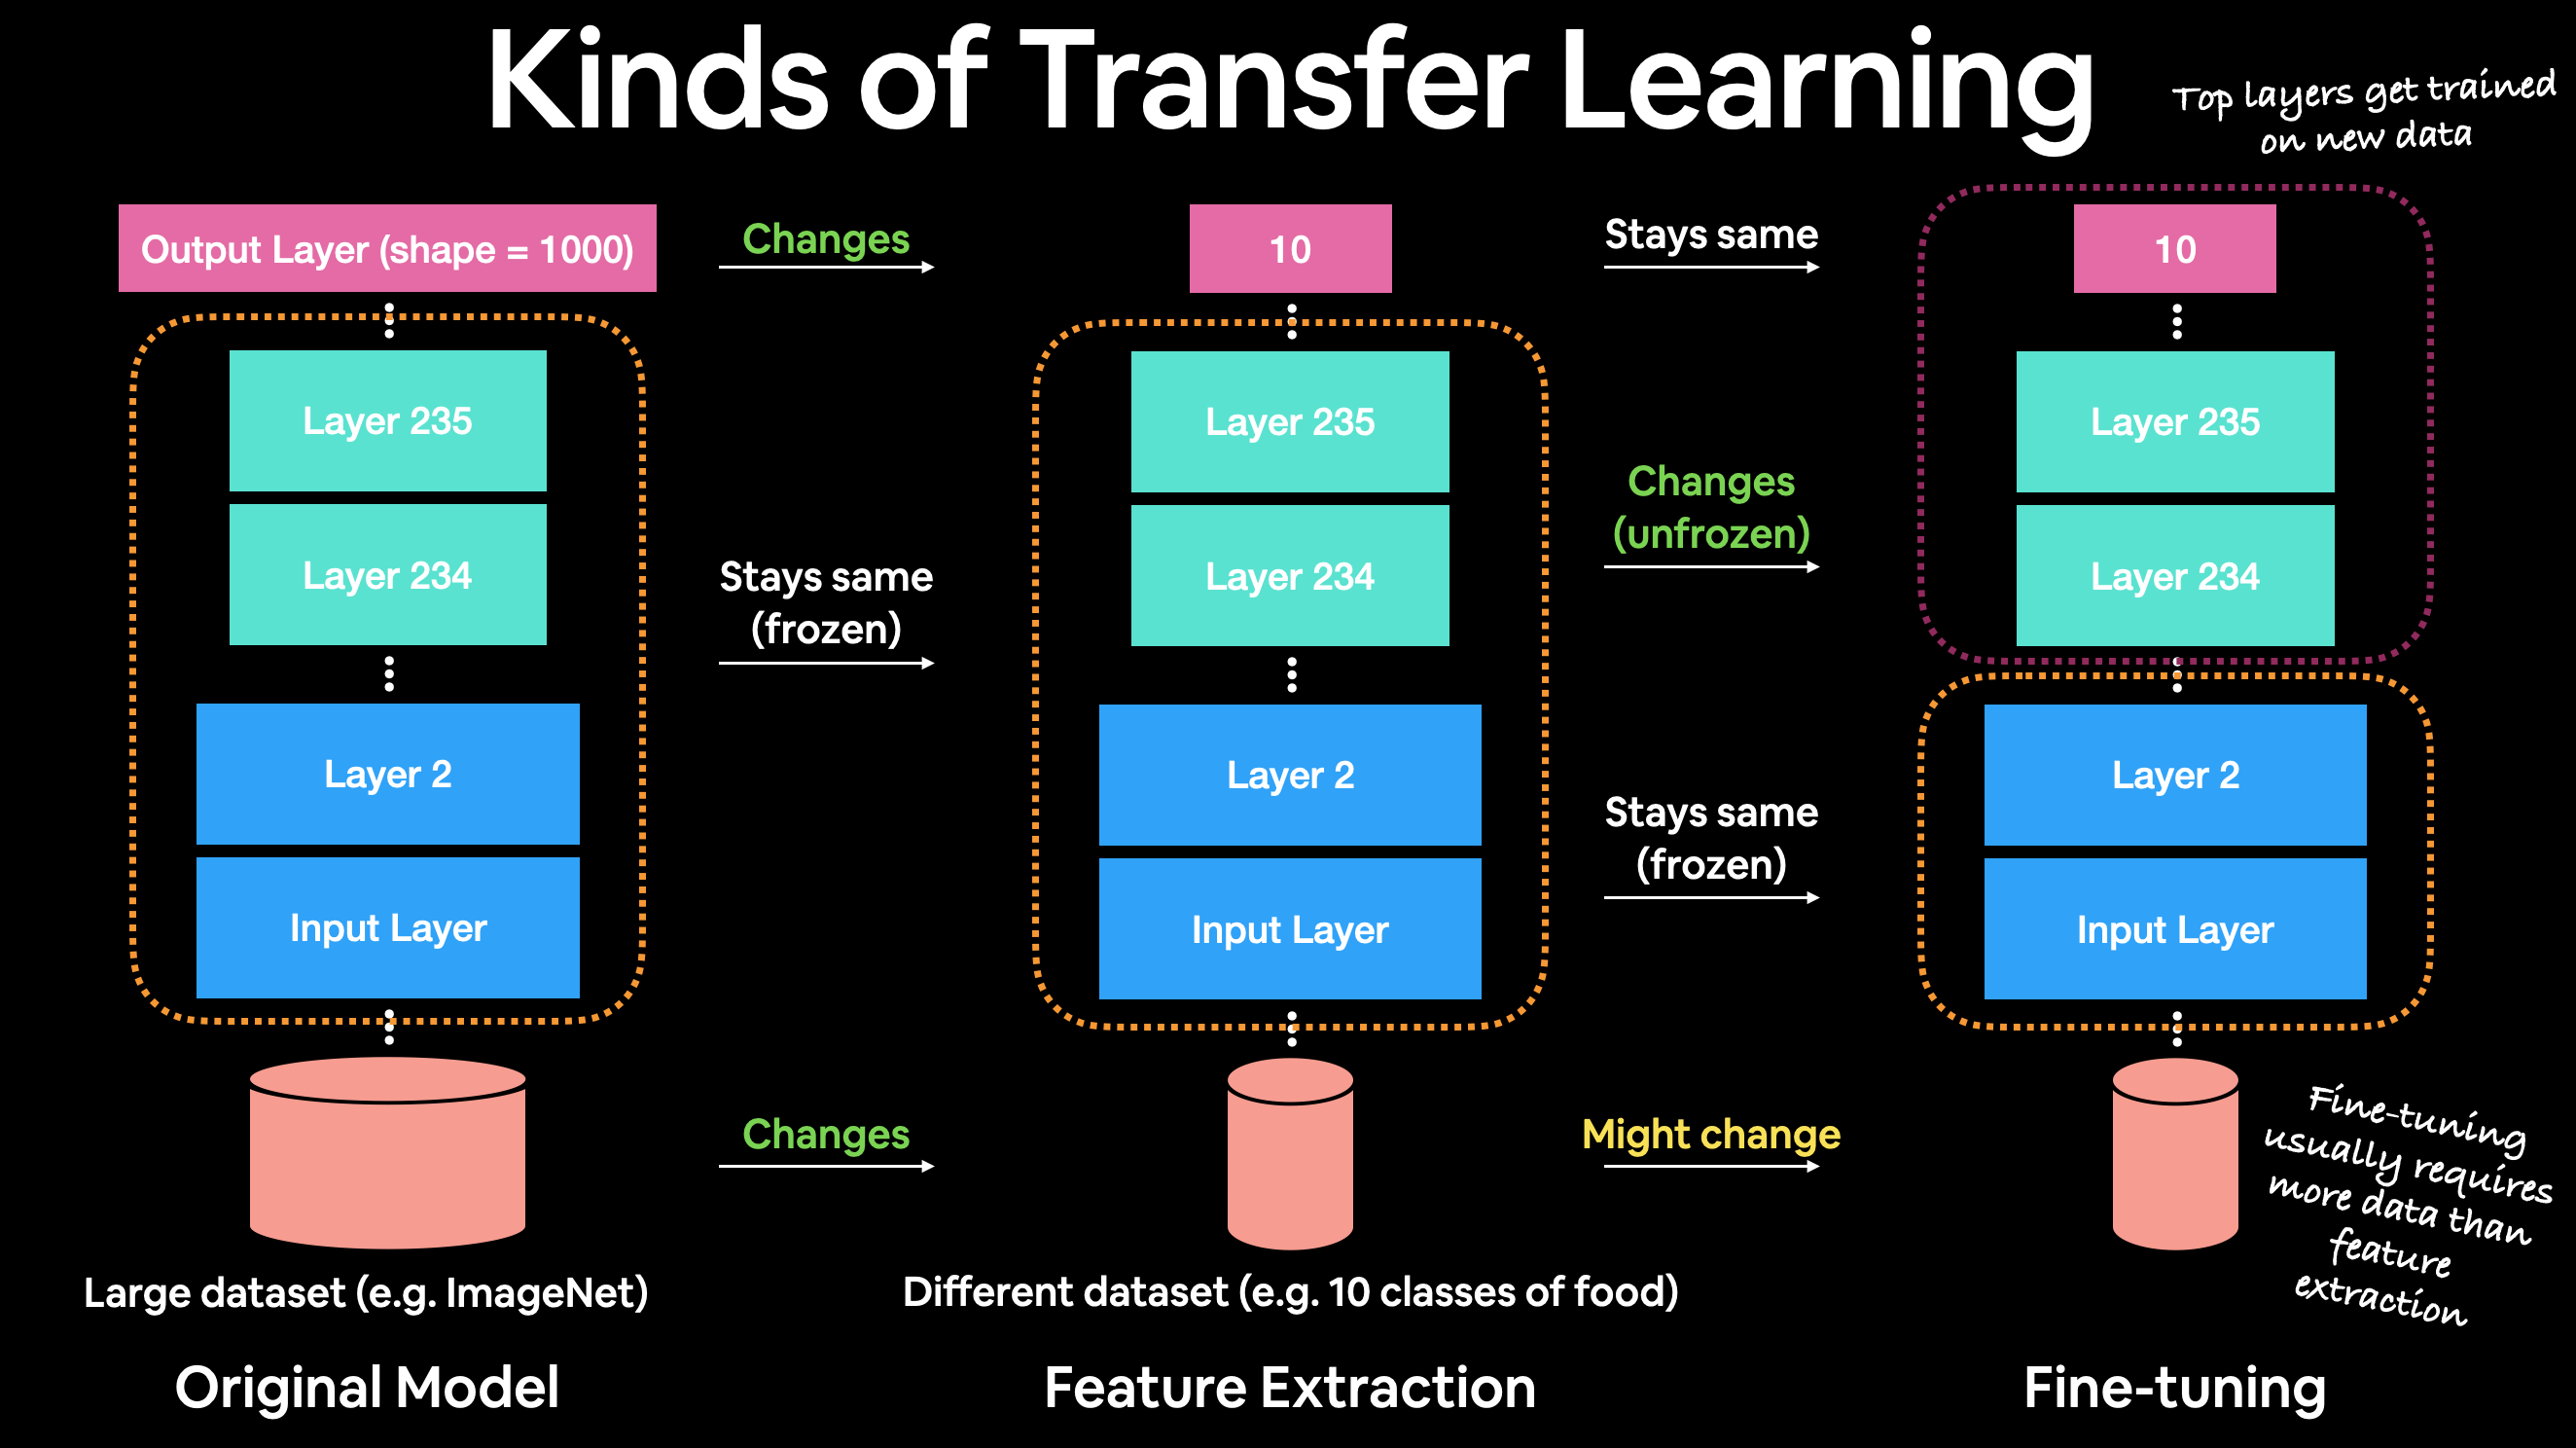

In [6]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [7]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# EfficientNet0 feature vector
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [15]:
# Let's make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url(str): A TensorFlow Hub feature extraction URL.
    num_classes(int): Number of output neurons in the output layer, 
      should be equal to number of target classes, default = 10

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor 
    layer and Dense output layer with num_classes output neurons.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable = False,   # freeze the already learned patterns
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,))  # define the input image shape
  
  # Create our image model
  model = tf.keras.Sequential([
     feature_extractor_layer,    # use the feature extraction layer as the base
     layers.Dense(num_classes, activation="softmax", name="output_layer")   # create our own output layer
  ])
  return model

## **Creating and testing ResNet TensorFlow Hub Feature Extraction model**

In [16]:
# Create ResNet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)
# Compile
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [17]:
# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=10,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",        # save experiment logs here
                                                                         experiment_name="resnet50V2")])   # name of log files

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20210513-171420
Epoch 1/10
24/24 [==============================] - 59s 1s/step - loss: 2.2916 - accuracy: 0.2468 - val_loss: 1.1800 - val_accuracy: 0.6304
Epoch 2/10
24/24 [==============================] - 20s 873ms/step - loss: 0.9398 - accuracy: 0.7315 - val_loss: 0.8648 - val_accuracy: 0.7296
Epoch 3/10
24/24 [==============================] - 21s 882ms/step - loss: 0.6396 - accuracy: 0.8170 - val_loss: 0.7549 - val_accuracy: 0.7544
Epoch 4/10
24/24 [==============================] - 20s 871ms/step - loss: 0.5154 - accuracy: 0.8581 - val_loss: 0.7233 - val_accuracy: 0.7664
Epoch 5/10
24/24 [==============================] - 20s 874ms/step - loss: 0.3604 - accuracy: 0.9190 - val_loss: 0.6766 - val_accuracy: 0.7844
Epoch 6/10
24/24 [==============================] - 21s 881ms/step - loss: 0.3004 - accuracy: 0.9476 - val_loss: 0.6851 - val_accuracy: 0.7756
Epoch 7/10
24/24 [==============================] - 20s 870ms/step - l

**Wow!**

*That. Is. Incredible. Our transfer learning feature extractor model out performed ALL of the previous models we built by hand... (substantially) and in a quicker training time AND with only 10% of the training examples.*



In [20]:
# Let's create a function to plot our loss curves...
# Tidbit: you could put a function like this into a script called "helper.py" and import it when you need it...
import matplotlib.pyplot as plt

# Plot the validation and training curves
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow History object.

  Returns:
    Plots of training/validation loss and accuracy metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

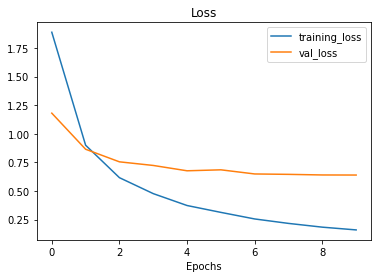

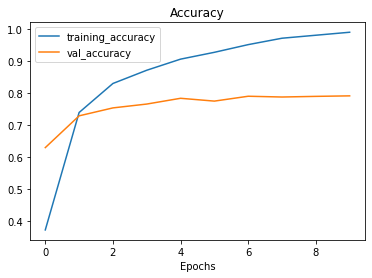

In [21]:
plot_loss_curves(resnet_history)

In [22]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


You can see the power of TensorFlow Hub here. The feature extraction layer has 23,564,800 parameters which are prelearned patterns the model has already learned on the ImageNet dataset. Since we set trainable=False, these patterns remain frozen (non-trainable) during training.

This means during training the model updates the 20,490 parameters in the output layer to suit our dataset.

## **Creating and testing EfficientNetB0  TensorFlow Hub Feature Extraction model**

In [24]:
# Create model
efficientnet_model = create_model(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model 
efficientnet_history = efficientnet_model.fit(train_data_10_percent, # only use 10% of training data
                                              epochs=10, # train for 10 epochs
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20210513-172843
Epoch 1/10
24/24 [==============================] - 31s 941ms/step - loss: 2.0620 - accuracy: 0.2821 - val_loss: 1.2692 - val_accuracy: 0.7252
Epoch 2/10
24/24 [==============================] - 18s 792ms/step - loss: 1.1128 - accuracy: 0.7912 - val_loss: 0.8518 - val_accuracy: 0.8188
Epoch 3/10
24/24 [==============================] - 18s 783ms/step - loss: 0.7962 - accuracy: 0.8300 - val_loss: 0.6865 - val_accuracy: 0.8504
Epoch 4/10
24/24 [==============================] - 18s 790ms/step - loss: 0.6388 - accuracy: 0.8717 - val_loss: 0.6029 - val_accuracy: 0.8580
Epoch 5/10
24/24 [==============================] - 18s 788ms/step - loss: 0.4896 - accuracy: 0.9002 - val_loss: 0.5504 - val_accuracy: 0.8640
Epoch 6/10
24/24 [==============================] - 18s 791ms/step - loss: 0.4240 - accuracy: 0.9163 - val_loss: 0.5173 - val_accuracy: 0.8668
Epoch 7/10
24/24 [==============================] - 18s 784ms/s

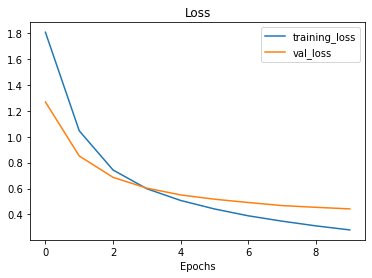

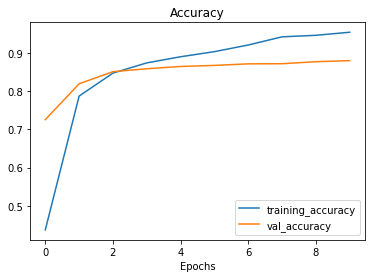

In [25]:
plot_loss_curves(efficientnet_history)

In [26]:
efficientnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


It seems despite having over four times less 
parameters `(4,049,564 vs. 23,564,800)` than the **ResNet50V2** extraction layer, the **EfficientNetB0** feature extraction layer yields better performance in the validation set. Now it's clear where the "efficient" name came from.



## **Comparing our model results using TensorBoard**
To upload a series of TensorFlow logs to TensorBoard, we use the following command where :
* --logdir is the target upload directory
* --name is the name of the experiment
* --description is a brief description of the experiment
* --one_shot exits the TensorBoard uploader once uploading is finished

In [27]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot

2021-05-13 17:42:34.432929: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2

In [28]:
# Check out what TensorBoard experiments you have
!tensorboard dev list

2021-05-13 17:48:18.222978: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
https://tensorboard.dev/experiment/mvdnVWTjQx2AxBJMvM6Otw/
	Name                 [No Name]
	Description          [No Description]
	Id                   mvdnVWTjQx2AxBJMvM6Otw
	Created              2021-05-13 17:43:05 (5 minutes ago)
	Updated              2021-05-13 17:43:12 (5 minutes ago)
	Runs                 6
	Tags                 3
	Scalars              84
	Tensor bytes         0
	Binary object bytes  10153263
Total: 1 experiment(s)


In [29]:
# Delete an experiment
# !tensorboard dev delete --experiment_id mvdnVWTjQx2AxBJMvM6Otw